# Team Skill Gap Analysis

Analyzing Team Member Skill Gaps and Improvement Recommendations

Caroline O’Sullivan (Boston University)  
Bhargavi Manyala (Boston University)  
Taylor Luckenbill (Boston University)

## Analyzing Team Skill Levels

In [4]:
import pandas as pd

skills_data = {
    "Name": ["Caroline", "Bhargavi", "Taylor"],
    "Python": [3, 3, 3],
    "SQL": [3, 3, 3],
    "Machine Learning": [2, 3, 3],
    "Cloud Computing": [2, 2, 1]
}

df_skills = pd.DataFrame(skills_data)
df_skills.set_index("Name", inplace=True)
df_skills

,Python,SQL,Machine Learning,Cloud Computing
Name,,,,
Caroline,3,3,2,2
Bhargavi,3,3,3,2
Taylor,3,3,3,1


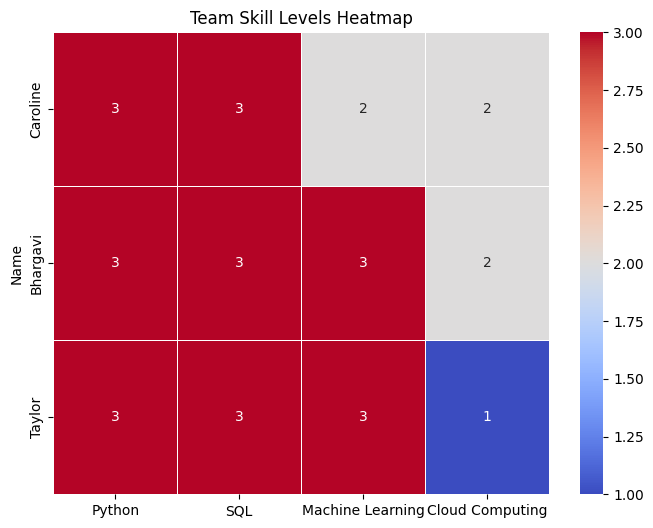

In [5]:
#Visualize Skill Levels
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df_skills, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Team Skill Levels Heatmap")
plt.savefig("team_skills_heatmap.png")
plt.show()

 # Compare team skills to Industry Requirements

## Data Cleaning


In [6]:

from pyspark.sql import SparkSession
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt



spark = SparkSession.builder \
    .appName("JobPostingsAnalysis") \
    .getOrCreate()

file_path = "lightcast_job_postings.csv"

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(file_path)

## Data Cleaning(Numeric Columns)
numeric_cols = [
    "DURATION", "COMPANY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE",
    "SALARY", "SALARY_TO", "SALARY_FROM", "MSA",
    "LOT_CAREER_AREA", "LOT_OCCUPATION", "LOT_SPECIALIZED_OCCUPATION",
    "LOT_OCCUPATION_GROUP", "NAICS_2022_2", "NAICS_2022_3",
    "NAICS_2022_4", "NAICS_2022_5", "NAICS_2022_6"
]

pandas_num = df.select(numeric_cols).toPandas()

pandas_num[numeric_cols] = pandas_num[numeric_cols].fillna(
    pandas_num[numeric_cols].median(numeric_only=True)
)

## Data Cleaning(Categorical Columns)
categorical_cols = [
    "COMPANY_NAME", "EDUCATION_LEVELS_NAME",
    "MIN_EDULEVELS_NAME", "MAX_EDULEVELS_NAME", "EMPLOYMENT_TYPE_NAME",
    "REMOTE_TYPE_NAME", "ORIGINAL_PAY_PERIOD", "LOCATION", "CITY_NAME",
    "COUNTY_NAME", "MSA_NAME", "STATE_NAME", "TITLE_CLEAN",
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
    "SOC_2021_4", "SOC_2021_4_NAME", "SOC_2021_5", "SOC_2021_5_NAME",
    "LOT_CAREER_AREA_NAME", "LOT_OCCUPATION_NAME",
    "LOT_SPECIALIZED_OCCUPATION_NAME", "LOT_OCCUPATION_GROUP_NAME",
    "NAICS_2022_2_NAME", "NAICS_2022_3_NAME", "NAICS_2022_4_NAME",
    "NAICS_2022_5_NAME", "NAICS_2022_6_NAME","SPECIALIZED_SKILLS_NAME","CERTIFICATIONS_NAME","COMMON_SKILLS_NAME","SOFTWARE_SKILLS_NAME"
]

pandas_cat = df.select(categorical_cols).toPandas()
pandas_cat[categorical_cols] = pandas_cat[categorical_cols].fillna("Unknown")

## Data Cleaning(Date Column)
date_cols = ["POSTED", "EXPIRED"]
pandas_date = df.select(date_cols).toPandas()

for col in date_cols:
    pandas_date[col] = pd.to_datetime(pandas_date[col], errors="coerce")
    pandas_date[col] = pandas_date[col].fillna(pandas_date[col].mode()[0])

pandas_handled_missing_values = pd.concat([pandas_num, pandas_cat, pandas_date], axis=1)


pandas_cleaned = pandas_handled_missing_values.drop_duplicates(
    subset=["TITLE_CLEAN", "COMPANY_NAME", "LOCATION","POSTED"],
    keep="first"
)




25/10/10 16:00:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## IT Skill Demand and Team Gap Analysis

In [7]:
it_jobs = pandas_cleaned[
    (pandas_cleaned["NAICS_2022_2_NAME"] == "Information") |
    (pandas_cleaned["NAICS_2022_2_NAME"] == "Professional, Scientific, and Technical Services")
][["NAICS_2022_2_NAME", "SPECIALIZED_SKILLS_NAME"]].copy()

it_jobs["SPECIALIZED_SKILLS_NAME"] = it_jobs["SPECIALIZED_SKILLS_NAME"].astype(str)
it_jobs["SPECIALIZED_SKILLS_NAME"] = it_jobs["SPECIALIZED_SKILLS_NAME"].str.replace("\n", " ")
it_jobs["SPECIALIZED_SKILLS_NAME"] = it_jobs["SPECIALIZED_SKILLS_NAME"].str.strip()


top_skills = ["Python", "SQL", "Machine Learning", "Cloud Computing"]

job_skill_counts = Counter()

for skill in top_skills:
    count = it_jobs["SPECIALIZED_SKILLS_NAME"].str.contains(skill, case=False).sum()
    job_skill_counts[skill] = count

print(" Most in-demand IT skills from job postings:")

for skill, count in job_skill_counts.most_common():
    print(f"{skill} appears in {count} IT job postings")

for skill in top_skills:
    if skill not in df_skills.columns:
        df_skills[skill] = 0  

df_skills

 Most in-demand IT skills from job postings:
SQL appears in 7498 IT job postings
Python appears in 4036 IT job postings
Machine Learning appears in 1578 IT job postings
Cloud Computing appears in 935 IT job postings


,Python,SQL,Machine Learning,Cloud Computing
Name,,,,
Caroline,3,3,2,2
Bhargavi,3,3,3,2
Taylor,3,3,3,1


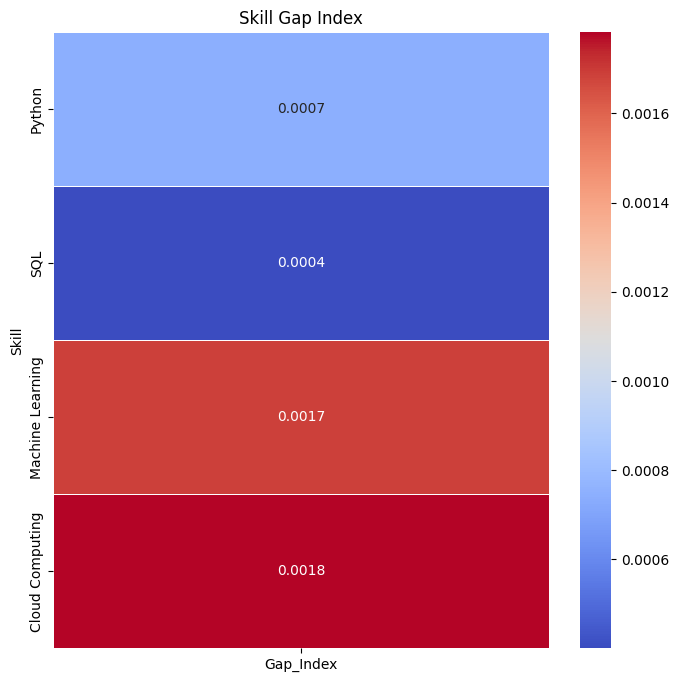

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame({
    "Skill": top_skills,
    "Job_Demand": [job_skill_counts[s] for s in top_skills],
    "Team_Skill": [df_skills[s].mean() for s in top_skills]
})


comparison_df["Gap_Index"] = comparison_df["Team_Skill"] / comparison_df["Job_Demand"]


plt.figure(figsize=(8,8))
sns.heatmap(comparison_df.set_index("Skill")[["Gap_Index"]], 
            annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)

plt.title("Skill Gap Index")
plt.ylabel("Skill")
plt.savefig("Skill_GapIndex_heatmap.png")
plt.show()


## Which Skills Should Each Team Member Prioritize Learning?

Based on the analysis above, all three team members should prioritize Cloud Computing in order to improve upon their beginner levels.  There are several ways that each team member can achieve this.  The most accessible option is enrolling in online courses.  For Cloud Computing, both Coursera and Codeacademy offer foundational courses on this topic, ranging from AWS specifically to platform agnostic overviews.  To improve upon Machine Learning skills, team members can leverage online courses hosted on Udemy or Coursera.  Both of these topics are taught through more formal avenues like certificate programs through universities, such as Stanford's Machine Learning Course.

All members are rated as average in Python and SQL, but there is always room for improvement. This area is an opportunity for collaboration, as members can bring different skills to the table and help troubleshoot each other's code.  To formally improve upon skills, they can utilize online courses on Coursera, Codeacademy, or Data Camp. In many cities, there are in person class options as well.  For example, General Assembly offers a variety of coding classes locally in NYC.  Each team member should choose the most convenient method to continue learning and improve upon their skillset in order to be competitive in the job market.